# Import Modules

In [1]:
import numpy as np
from fourrooms import Fourrooms
from IPython.display import clear_output
from aoaoc_tabular import *
import matplotlib.pyplot as plt
from visualize import Visualization

# HyperParameters

In [2]:
# Replace the command line argparse
class Arguments:
    def __init__(self):
        # Numbers
        self.nepisodes=3000
        self.nruns=1
        self.nsteps=2000
        self.noptions=2
        
        # Learning Rates
        self.lr_term=0.1
        self.lr_intra=0.25
        self.lr_critic=0.5
        self.lr_criticA=0.5
        self.lr_attend=0.02
        
        # Environment Parameters
        self.discount=0.99
        self.deterministic = False
        self.punishEachStep = True
        self.modified = True
        
        # Attention Parameters
        self.h_learn = True
        self.normalize = True
               
        # Policy Parameters
        self.epsilon=1e-1
        self.temp=1.
        
        # Objective Parameters
        self.wo1 = 0.5   #q
        self.wo2 = 2.    #cosim
        self.wo3 = 0.    #entropy
        self.wo4 = 0.    #size
        
        # Randomness Parameters
        self.seed=2222
        self.seed_startstate=1111
        
        # Display Parameters
        self.showMap = False
        self.showAttention = False
        self.showOptPref = False
        self.showFrequency = 10
        
        # Other Parameters
        self.baseline=True
        self.dc = 2.
        
        
args = Arguments()

## Independent variables

In [6]:
# Changing self.wo2 and self.dc
runs = 1
algo = "aoaoc"

wo2List = [0, 0.5, 1, 2, 4]
dcList = [0.5, 1, 2, 3]
aoaocSet = []
for wo in wo2List:
    for dc in dcList:
        aoaocSet.append([wo, dc])
        
dcSet = [0, 0.5, 1, 2, 3, 4, 5]

testSet = aoaocSet if algo=="aoaoc" else (dcSet if algo=="dc" else [0])

# Run

## Set up

In [3]:
rng = np.random.RandomState(args.seed)
env = Fourrooms(args.seed_startstate, args.punishEachStep, args.deterministic, args.modified)

possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]

features = Tabular(env.observation_space)
nfeatures, nactions = len(features), env.action_space

viz = Visualization(env, args, nactions)

## Main loop

In [7]:
for i in testSet:
    if algo=="aoaoc":
        args.wo2 = i[0]
        args.dc = i[1]
    if algo=="dc":
        args.dc = i
    for r in range(runs):
        # Set up classes
        policy_over_options = POO(rng, nfeatures, args)
        CoSimObj.reset()
        options = [Option(rng, nfeatures, nactions, args, policy_over_options, i) for i in range(args.noptions)]

        # Loop through games
        for episode in range(args.nepisodes):
            # Initial state
            return_per_episode = 0.0
            observation = env.reset()
            phi = features(observation)    
            option = policy_over_options.sample(phi)
            action = options[option].sample(phi)
            traject = [[phi,option],[phi,option],action]
            viz.resetMap(phi)

            # Reset record
            cumreward = 0.
            duration = 1
            option_switches = 0
            avgduration = 0.

            # Loop through frames in 1 game
            for step in range(args.nsteps):
                # Collect feedback from environment
                observation, reward, done, _ = env.step(action)
                phi = features(observation)
                return_per_episode += pow(args.discount,step)*reward

                # Render
                if args.showMap and episode % 100 == 99:
                    clear_output(wait=True)
                    viz.showMap(phi, option)

                # Store option index
                last_option = option

                # Check termination
                termination = options[option].terminate(phi, value=True)
                if options[option].terminate(phi):
                    option = policy_over_options.sample(phi)
                    option_switches += 1
                    avgduration += (1./option_switches)*(duration - avgduration)
                    duration = 1

                # Record into trajectory
                traject[0] = traject[1]
                traject[1] = [phi, option]
                traject[2] = action

                # Sample next action
                action = options[option].sample(phi)

                # Policy Evaluation + Policy Improvement
                baseline = policy_over_options.value(traject[0][0], traject[0][1])
                advantage = policy_over_options.advantage(phi, last_option)
                options[last_option].update(traject, reward, done, phi, last_option, termination, baseline, advantage)
                policy_over_options.update(traject, reward, done, termination)

                # End of frame
                cumreward += reward
                duration += 1
                if done:
                    break

            # Attention graph
            if episode % args.showFrequency == 0:
                if args.showAttention:
                    clear_output(wait=True)
                    viz.showAttention(options)
                if args.showOptPref:
                    clear_output(wait=True)
                    viz.showPref(policy_over_options.weights)
        if (algo=="aoaoc" or algo=="dc"):
            print('Wo {} Dc {} Run {} episode {} steps {} cumreward {} avg. duration {} switches {}'.format(args.wo2, args.dc, r, episode, step, cumreward, avgduration, option_switches))
        else:
            print('Run {} episode {} steps {} cumreward {} avg. duration {} switches {}'.format(r, episode, step, cumreward, avgduration, option_switches))
        if (algo=="aoaoc"):
            viz.savePref(policy_over_options.weights, algo="aoaoc", wo=i[0], dc=i[1], run=r)
        if (algo=="dc"):
            viz.savePref(policy_over_options.weights, algo="dc", dc=i, run=r)

Run 0 episode 0 steps 58 cumreward -66.0 avg. duration 3.3333333333333335 switches 24
Run 0 episode 1 steps 19 cumreward 12.0 avg. duration 2.4615384615384612 switches 13
Run 0 episode 2 steps 64 cumreward -78.0 avg. duration 3.2500000000000004 switches 28
Run 0 episode 3 steps 33 cumreward -16.0 avg. duration 2.6842105263157903 switches 19
Run 0 episode 4 steps 280 cumreward -510.0 avg. duration 2.9858156028368796 switches 141
Run 0 episode 5 steps 266 cumreward -482.0 avg. duration 2.9275362318840554 switches 138
Run 0 episode 6 steps 32 cumreward -14.0 avg. duration 2.7222222222222228 switches 18
Run 0 episode 7 steps 98 cumreward -146.0 avg. duration 2.9019607843137254 switches 51
Run 0 episode 8 steps 252 cumreward -454.0 avg. duration 3.270270270270271 switches 111
Run 0 episode 9 steps 214 cumreward -378.0 avg. duration 3.27659574468085 switches 94
Run 0 episode 10 steps 122 cumreward -194.0 avg. duration 3.5000000000000013 switches 48
Run 0 episode 11 steps 295 cumreward -540.0

Run 0 episode 104 steps 53 cumreward -56.0 avg. duration 3.523809523809524 switches 21
Run 0 episode 105 steps 33 cumreward -16.0 avg. duration 4.5555555555555545 switches 9
Run 0 episode 106 steps 18 cumreward 14.0 avg. duration 3.125 switches 8
Run 0 episode 107 steps 13 cumreward 24.0 avg. duration 2.3333333333333335 switches 9
Run 0 episode 108 steps 21 cumreward 8.0 avg. duration 3.8571428571428568 switches 7
Run 0 episode 109 steps 13 cumreward 24.0 avg. duration 3.0 switches 6
Run 0 episode 110 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episode 111 steps 5 cumreward 40.0 avg. duration 2.5 switches 2
Run 0 episode 112 steps 33 cumreward -16.0 avg. duration 3.9090909090909087 switches 11
Run 0 episode 113 steps 30 cumreward -10.0 avg. duration 3.6363636363636362 switches 11
Run 0 episode 114 steps 17 cumreward 16.0 avg. duration 3.2857142857142856 switches 7
Run 0 episode 115 steps 6 cumreward 38.0 avg. duration 2.6666666666666665 switches 3
Run 0 episode 116 steps 

Run 0 episode 218 steps 40 cumreward -30.0 avg. duration 3.1666666666666665 switches 18
Run 0 episode 219 steps 4 cumreward 42.0 avg. duration 1.75 switches 4
Run 0 episode 220 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Run 0 episode 221 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3
Run 0 episode 222 steps 13 cumreward 24.0 avg. duration 2.5 switches 8
Run 0 episode 223 steps 7 cumreward 36.0 avg. duration 2.75 switches 4
Run 0 episode 224 steps 8 cumreward 34.0 avg. duration 2.75 switches 4
Run 0 episode 225 steps 21 cumreward 8.0 avg. duration 3.2222222222222223 switches 9
Run 0 episode 226 steps 41 cumreward -32.0 avg. duration 3.857142857142857 switches 14
Run 0 episode 227 steps 16 cumreward 18.0 avg. duration 3.2857142857142856 switches 7
Run 0 episode 228 steps 28 cumreward -6.0 avg. duration 4.857142857142857 switches 7
Run 0 episode 229 steps 14 cumreward 22.0 avg. duration 2.0 switches 13
Run 0 episode 230 steps 45 cumreward -40.0 avg. duration 3

Run 0 episode 323 steps 21 cumreward 8.0 avg. duration 3.2222222222222223 switches 9
Run 0 episode 324 steps 5 cumreward 40.0 avg. duration 2.3333333333333335 switches 3
Run 0 episode 325 steps 3 cumreward 44.0 avg. duration 3.0 switches 1
Run 0 episode 326 steps 16 cumreward 18.0 avg. duration 3.5 switches 6
Run 0 episode 327 steps 11 cumreward 28.0 avg. duration 3.0 switches 5
Run 0 episode 328 steps 9 cumreward 32.0 avg. duration 3.0 switches 4
Run 0 episode 329 steps 7 cumreward 36.0 avg. duration 1.8571428571428572 switches 7
Run 0 episode 330 steps 16 cumreward 18.0 avg. duration 2.7777777777777777 switches 9
Run 0 episode 331 steps 13 cumreward 24.0 avg. duration 4.0 switches 4
Run 0 episode 332 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Run 0 episode 333 steps 10 cumreward 30.0 avg. duration 5.5 switches 2
Run 0 episode 334 steps 15 cumreward 20.0 avg. duration 3.3333333333333335 switches 6
Run 0 episode 335 steps 14 cumreward 22.0 avg. duration 3.166666666666667 switc

Run 0 episode 434 steps 5 cumreward 40.0 avg. duration 1.8 switches 5
Run 0 episode 435 steps 9 cumreward 32.0 avg. duration 1.8888888888888888 switches 9
Run 0 episode 436 steps 10 cumreward 30.0 avg. duration 3.0 switches 4
Run 0 episode 437 steps 21 cumreward 8.0 avg. duration 2.818181818181818 switches 11
Run 0 episode 438 steps 15 cumreward 20.0 avg. duration 3.8 switches 5
Run 0 episode 439 steps 4 cumreward 42.0 avg. duration 2.0 switches 2
Run 0 episode 440 steps 37 cumreward -24.0 avg. duration 2.8947368421052633 switches 19
Run 0 episode 441 steps 12 cumreward 26.0 avg. duration 11.0 switches 1
Run 0 episode 442 steps 6 cumreward 38.0 avg. duration 5.0 switches 1
Run 0 episode 443 steps 11 cumreward 28.0 avg. duration 4.0 switches 3
Run 0 episode 444 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Run 0 episode 445 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3
Run 0 episode 446 steps 11 cumreward 28.0 avg. duration 3.0 switches 5
Run 0 episode 447 ste

Run 0 episode 542 steps 36 cumreward -22.0 avg. duration 3.9166666666666656 switches 12
Run 0 episode 543 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Run 0 episode 544 steps 11 cumreward 28.0 avg. duration 2.4285714285714284 switches 7
Run 0 episode 545 steps 11 cumreward 28.0 avg. duration 4.333333333333333 switches 3
Run 0 episode 546 steps 5 cumreward 40.0 avg. duration 2.0 switches 4
Run 0 episode 547 steps 6 cumreward 38.0 avg. duration 2.0 switches 5
Run 0 episode 548 steps 10 cumreward 30.0 avg. duration 2.5 switches 6
Run 0 episode 549 steps 56 cumreward -62.0 avg. duration 3.8947368421052633 switches 19
Run 0 episode 550 steps 31 cumreward -12.0 avg. duration 4.75 switches 8
Run 0 episode 551 steps 11 cumreward 28.0 avg. duration 10.0 switches 1
Run 0 episode 552 steps 5 cumreward 40.0 avg. duration 2.0 switches 4
Run 0 episode 553 steps 28 cumreward -6.0 avg. duration 3.4545454545454546 switches 11
Run 0 episode 554 steps 1 cumreward 48.0 avg. duration 2.0 switches 1


Run 0 episode 654 steps 32 cumreward -14.0 avg. duration 4.444444444444445 switches 9
Run 0 episode 655 steps 11 cumreward 28.0 avg. duration 6.0 switches 2
Run 0 episode 656 steps 6 cumreward 38.0 avg. duration 1.8 switches 5
Run 0 episode 657 steps 20 cumreward 10.0 avg. duration 3.375 switches 8
Run 0 episode 658 steps 15 cumreward 20.0 avg. duration 3.0 switches 7
Run 0 episode 659 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Run 0 episode 660 steps 22 cumreward 6.0 avg. duration 3.1 switches 10
Run 0 episode 661 steps 10 cumreward 30.0 avg. duration 2.1250000000000004 switches 8
Run 0 episode 662 steps 10 cumreward 30.0 avg. duration 5.0 switches 2
Run 0 episode 663 steps 17 cumreward 16.0 avg. duration 3.0 switches 8
Run 0 episode 664 steps 12 cumreward 26.0 avg. duration 3.2 switches 5
Run 0 episode 665 steps 8 cumreward 34.0 avg. duration 2.4 switches 5
Run 0 episode 666 steps 11 cumreward 28.0 avg. duration 10.0 switches 1
Run 0 episode 667 steps 17 cumreward 16.0 avg. 

Run 0 episode 761 steps 16 cumreward 18.0 avg. duration 4.75 switches 4
Run 0 episode 762 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 763 steps 12 cumreward 26.0 avg. duration 3.75 switches 4
Run 0 episode 764 steps 17 cumreward 16.0 avg. duration 5.0 switches 4
Run 0 episode 765 steps 10 cumreward 30.0 avg. duration 2.5 switches 6
Run 0 episode 766 steps 15 cumreward 20.0 avg. duration 2.75 switches 8
Run 0 episode 767 steps 14 cumreward 22.0 avg. duration 7.5 switches 2
Run 0 episode 768 steps 16 cumreward 18.0 avg. duration 3.142857142857143 switches 7
Run 0 episode 769 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 770 steps 15 cumreward 20.0 avg. duration 8.0 switches 2
Run 0 episode 771 steps 31 cumreward -12.0 avg. duration 3.4999999999999996 switches 12
Run 0 episode 772 steps 39 cumreward -28.0 avg. duration 3.533333333333333 switches 15
Run 0 episode 773 steps 3 cumreward 44.0 avg. duration 2.0 switches 2
Run 0 episode 774 steps 3 cumr

Run 0 episode 877 steps 11 cumreward 28.0 avg. duration 2.25 switches 8
Run 0 episode 878 steps 11 cumreward 28.0 avg. duration 6.0 switches 2
Run 0 episode 879 steps 13 cumreward 24.0 avg. duration 3.4 switches 5
Run 0 episode 880 steps 18 cumreward 14.0 avg. duration 2.545454545454545 switches 11
Run 0 episode 881 steps 10 cumreward 30.0 avg. duration 3.25 switches 4
Run 0 episode 882 steps 26 cumreward -2.0 avg. duration 2.388888888888889 switches 18
Run 0 episode 883 steps 7 cumreward 36.0 avg. duration 3.0 switches 3
Run 0 episode 884 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Run 0 episode 885 steps 11 cumreward 28.0 avg. duration 2.666666666666667 switches 6
Run 0 episode 886 steps 13 cumreward 24.0 avg. duration 4.0 switches 4
Run 0 episode 887 steps 29 cumreward -8.0 avg. duration 6.6 switches 5
Run 0 episode 888 steps 22 cumreward 6.0 avg. duration 3.9999999999999996 switches 7
Run 0 episode 889 steps 4 cumreward 42.0 avg. duration 2.0 switches 3
Run 0 episode 890 st

Run 0 episode 989 steps 15 cumreward 20.0 avg. duration 2.75 switches 8
Run 0 episode 990 steps 14 cumreward 22.0 avg. duration 4.0 switches 4
Run 0 episode 991 steps 6 cumreward 38.0 avg. duration 3.0 switches 2
Run 0 episode 992 steps 16 cumreward 18.0 avg. duration 2.5 switches 10
Run 0 episode 993 steps 15 cumreward 20.0 avg. duration 3.3333333333333335 switches 6
Run 0 episode 994 steps 6 cumreward 38.0 avg. duration 2.6666666666666665 switches 3
Run 0 episode 995 steps 23 cumreward 4.0 avg. duration 4.5 switches 6
Run 0 episode 996 steps 14 cumreward 22.0 avg. duration 3.6 switches 5
Run 0 episode 997 steps 46 cumreward -42.0 avg. duration 2.9130434782608696 switches 23
Run 0 episode 998 steps 10 cumreward 30.0 avg. duration 2.5 switches 6
Run 0 episode 999 steps 2 cumreward 46.0 avg. duration 1.6666666666666667 switches 3
Run 0 episode 1000 steps 27 cumreward -4.0 avg. duration 4.25 switches 8
Run 0 episode 1001 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Run 0 episode 1

Run 0 episode 1100 steps 7 cumreward 36.0 avg. duration 2.5 switches 4
Run 0 episode 1101 steps 16 cumreward 18.0 avg. duration 8.5 switches 2
Run 0 episode 1102 steps 24 cumreward 2.0 avg. duration 3.3000000000000003 switches 10
Run 0 episode 1103 steps 16 cumreward 18.0 avg. duration 4.0 switches 5
Run 0 episode 1104 steps 20 cumreward 10.0 avg. duration 3.375 switches 8
Run 0 episode 1105 steps 45 cumreward -40.0 avg. duration 3.1499999999999995 switches 20
Run 0 episode 1106 steps 8 cumreward 34.0 avg. duration 2.4 switches 5
Run 0 episode 1107 steps 8 cumreward 34.0 avg. duration 3.3333333333333335 switches 3
Run 0 episode 1108 steps 26 cumreward -2.0 avg. duration 2.666666666666667 switches 15
Run 0 episode 1109 steps 29 cumreward -8.0 avg. duration 3.153846153846154 switches 13
Run 0 episode 1110 steps 8 cumreward 34.0 avg. duration 1.875 switches 8
Run 0 episode 1111 steps 21 cumreward 8.0 avg. duration 2.5 switches 14
Run 0 episode 1112 steps 40 cumreward -30.0 avg. duration 4

Run 0 episode 1211 steps 16 cumreward 18.0 avg. duration 2.5 switches 10
Run 0 episode 1212 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 1213 steps 10 cumreward 30.0 avg. duration 2.8 switches 5
Run 0 episode 1214 steps 12 cumreward 26.0 avg. duration 2.714285714285714 switches 7
Run 0 episode 1215 steps 10 cumreward 30.0 avg. duration 5.0 switches 2
Run 0 episode 1216 steps 11 cumreward 28.0 avg. duration 6.0 switches 2
Run 0 episode 1217 steps 15 cumreward 20.0 avg. duration 3.0 switches 7
Run 0 episode 1218 steps 27 cumreward -4.0 avg. duration 4.714285714285714 switches 7
Run 0 episode 1219 steps 11 cumreward 28.0 avg. duration 2.428571428571429 switches 7
Run 0 episode 1220 steps 8 cumreward 34.0 avg. duration 2.4 switches 5
Run 0 episode 1221 steps 5 cumreward 40.0 avg. duration 3.0 switches 2
Run 0 episode 1222 steps 32 cumreward -14.0 avg. duration 2.6315789473684212 switches 19
Run 0 episode 1223 steps 13 cumreward 24.0 avg. duration 2.0 switches 12
Run 0 

Run 0 episode 1319 steps 5 cumreward 40.0 avg. duration 2.3333333333333335 switches 3
Run 0 episode 1320 steps 22 cumreward 6.0 avg. duration 11.0 switches 2
Run 0 episode 1321 steps 17 cumreward 16.0 avg. duration 6.333333333333334 switches 3
Run 0 episode 1322 steps 18 cumreward 14.0 avg. duration 4.4 switches 5
Run 0 episode 1323 steps 11 cumreward 28.0 avg. duration 5.5 switches 2
Run 0 episode 1324 steps 23 cumreward 4.0 avg. duration 2.8333333333333335 switches 12
Run 0 episode 1325 steps 12 cumreward 26.0 avg. duration 6.0 switches 2
Run 0 episode 1326 steps 3 cumreward 44.0 avg. duration 2.0 switches 2
Run 0 episode 1327 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3
Run 0 episode 1328 steps 15 cumreward 20.0 avg. duration 4.5 switches 4
Run 0 episode 1329 steps 21 cumreward 8.0 avg. duration 4.333333333333333 switches 6
Run 0 episode 1330 steps 15 cumreward 20.0 avg. duration 3.0 switches 7
Run 0 episode 1331 steps 32 cumreward -14.0 avg. duration 2.7222222

Run 0 episode 1427 steps 11 cumreward 28.0 avg. duration 2.0 switches 10
Run 0 episode 1428 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episode 1429 steps 28 cumreward -6.0 avg. duration 3.3333333333333335 switches 12
Run 0 episode 1430 steps 16 cumreward 18.0 avg. duration 2.8750000000000004 switches 8
Run 0 episode 1431 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 1432 steps 9 cumreward 32.0 avg. duration 2.0 switches 7
Run 0 episode 1433 steps 7 cumreward 36.0 avg. duration 6.0 switches 1
Run 0 episode 1434 steps 23 cumreward 4.0 avg. duration 3.2 switches 10
Run 0 episode 1435 steps 18 cumreward 14.0 avg. duration 2.307692307692308 switches 13
Run 0 episode 1436 steps 11 cumreward 28.0 avg. duration 2.4285714285714284 switches 7
Run 0 episode 1437 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episode 1438 steps 14 cumreward 22.0 avg. duration 3.6 switches 5
Run 0 episode 1439 steps 13 cumreward 24.0 avg. duration 7.0 switches 2
Run 0 e

Run 0 episode 1535 steps 27 cumreward -4.0 avg. duration 2.3684210526315788 switches 19
Run 0 episode 1536 steps 23 cumreward 4.0 avg. duration 4.666666666666667 switches 6
Run 0 episode 1537 steps 31 cumreward -12.0 avg. duration 2.7647058823529416 switches 17
Run 0 episode 1538 steps 18 cumreward 14.0 avg. duration 9.0 switches 2
Run 0 episode 1539 steps 4 cumreward 42.0 avg. duration 3.0 switches 1
Run 0 episode 1540 steps 3 cumreward 44.0 avg. duration 2.0 switches 1
Run 0 episode 1541 steps 10 cumreward 30.0 avg. duration 3.666666666666667 switches 3
Run 0 episode 1542 steps 16 cumreward 18.0 avg. duration 2.75 switches 8
Run 0 episode 1543 steps 38 cumreward -26.0 avg. duration 3.642857142857143 switches 14
Run 0 episode 1544 steps 11 cumreward 28.0 avg. duration 2.4285714285714284 switches 7
Run 0 episode 1545 steps 15 cumreward 20.0 avg. duration 3.6 switches 5
Run 0 episode 1546 steps 10 cumreward 30.0 avg. duration 3.6666666666666665 switches 3
Run 0 episode 1547 steps 17 cum

Run 0 episode 1645 steps 9 cumreward 32.0 avg. duration 3.0 switches 4
Run 0 episode 1646 steps 9 cumreward 32.0 avg. duration 4.5 switches 2
Run 0 episode 1647 steps 31 cumreward -12.0 avg. duration 2.6666666666666665 switches 18
Run 0 episode 1648 steps 16 cumreward 18.0 avg. duration 8.0 switches 2
Run 0 episode 1649 steps 11 cumreward 28.0 avg. duration 2.25 switches 8
Run 0 episode 1650 steps 23 cumreward 4.0 avg. duration 22.0 switches 1
Run 0 episode 1651 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 1652 steps 8 cumreward 34.0 avg. duration 2.4 switches 5
Run 0 episode 1653 steps 9 cumreward 32.0 avg. duration 3.666666666666667 switches 3
Run 0 episode 1654 steps 14 cumreward 22.0 avg. duration 7.0 switches 2
Run 0 episode 1655 steps 13 cumreward 24.0 avg. duration 7.0 switches 2
Run 0 episode 1656 steps 2 cumreward 46.0 avg. duration 2.0 switches 1
Run 0 episode 1657 steps 12 cumreward 26.0 avg. duration 11.0 switches 1
Run 0 episode 1658 steps 14 cumreward

Run 0 episode 1755 steps 11 cumreward 28.0 avg. duration 3.5 switches 4
Run 0 episode 1756 steps 10 cumreward 30.0 avg. duration 4.0 switches 3
Run 0 episode 1757 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episode 1758 steps 21 cumreward 8.0 avg. duration 3.5 switches 8
Run 0 episode 1759 steps 8 cumreward 34.0 avg. duration 2.75 switches 4
Run 0 episode 1760 steps 17 cumreward 16.0 avg. duration 3.6666666666666665 switches 6
Run 0 episode 1761 steps 26 cumreward -2.0 avg. duration 5.166666666666667 switches 6
Run 0 episode 1762 steps 6 cumreward 38.0 avg. duration 1.8333333333333335 switches 6
Run 0 episode 1763 steps 26 cumreward -2.0 avg. duration 4.125 switches 8
Run 0 episode 1764 steps 13 cumreward 24.0 avg. duration 3.9999999999999996 switches 4
Run 0 episode 1765 steps 8 cumreward 34.0 avg. duration 4.5 switches 2
Run 0 episode 1766 steps 24 cumreward 2.0 avg. duration 3.0909090909090913 switches 11
Run 0 episode 1767 steps 11 cumreward 28.0 avg. duration 3.25 sw

Run 0 episode 1863 steps 13 cumreward 24.0 avg. duration 7.0 switches 2
Run 0 episode 1864 steps 40 cumreward -30.0 avg. duration 2.9499999999999997 switches 20
Run 0 episode 1865 steps 25 cumreward 0.0 avg. duration 4.428571428571429 switches 7
Run 0 episode 1866 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episode 1867 steps 7 cumreward 36.0 avg. duration 6.0 switches 1
Run 0 episode 1868 steps 6 cumreward 38.0 avg. duration 5.0 switches 1
Run 0 episode 1869 steps 13 cumreward 24.0 avg. duration 2.714285714285714 switches 7
Run 0 episode 1870 steps 13 cumreward 24.0 avg. duration 4.0 switches 4
Run 0 episode 1871 steps 23 cumreward 4.0 avg. duration 2.571428571428571 switches 14
Run 0 episode 1872 steps 7 cumreward 36.0 avg. duration 2.0 switches 6
Run 0 episode 1873 steps 3 cumreward 44.0 avg. duration 2.0 switches 2
Run 0 episode 1874 steps 9 cumreward 32.0 avg. duration 2.142857142857143 switches 7
Run 0 episode 1875 steps 10 cumreward 30.0 avg. duration 2.0 switches 

Run 0 episode 1971 steps 27 cumreward -4.0 avg. duration 2.7333333333333334 switches 15
Run 0 episode 1972 steps 11 cumreward 28.0 avg. duration 2.2500000000000004 switches 8
Run 0 episode 1973 steps 8 cumreward 34.0 avg. duration 2.5 switches 4
Run 0 episode 1974 steps 1 cumreward 48.0 avg. duration 0.0 switches 0
Run 0 episode 1975 steps 12 cumreward 26.0 avg. duration 6.0 switches 2
Run 0 episode 1976 steps 14 cumreward 22.0 avg. duration 4.25 switches 4
Run 0 episode 1977 steps 16 cumreward 18.0 avg. duration 3.5 switches 6
Run 0 episode 1978 steps 13 cumreward 24.0 avg. duration 4.666666666666667 switches 3
Run 0 episode 1979 steps 8 cumreward 34.0 avg. duration 2.75 switches 4
Run 0 episode 1980 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 1981 steps 34 cumreward -18.0 avg. duration 5.125000000000001 switches 8
Run 0 episode 1982 steps 15 cumreward 20.0 avg. duration 4.25 switches 4
Run 0 episode 1983 steps 10 cumreward 30.0 avg. duration 2.6 switches 5
Run 0

Run 0 episode 2083 steps 5 cumreward 40.0 avg. duration 1.8 switches 5
Run 0 episode 2084 steps 3 cumreward 44.0 avg. duration 2.0 switches 1
Run 0 episode 2085 steps 22 cumreward 6.0 avg. duration 8.0 switches 3
Run 0 episode 2086 steps 10 cumreward 30.0 avg. duration 3.25 switches 4
Run 0 episode 2087 steps 17 cumreward 16.0 avg. duration 6.333333333333334 switches 3
Run 0 episode 2088 steps 12 cumreward 26.0 avg. duration 3.75 switches 4
Run 0 episode 2089 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 2090 steps 9 cumreward 32.0 avg. duration 2.6 switches 5
Run 0 episode 2091 steps 15 cumreward 20.0 avg. duration 8.0 switches 2
Run 0 episode 2092 steps 5 cumreward 40.0 avg. duration 2.3333333333333335 switches 3
Run 0 episode 2093 steps 15 cumreward 20.0 avg. duration 5.666666666666667 switches 3
Run 0 episode 2094 steps 11 cumreward 28.0 avg. duration 2.6666666666666665 switches 6
Run 0 episode 2095 steps 29 cumreward -8.0 avg. duration 5.0 switches 7
Run 0 epis

Run 0 episode 2197 steps 32 cumreward -14.0 avg. duration 2.476190476190477 switches 21
Run 0 episode 2198 steps 7 cumreward 36.0 avg. duration 2.0 switches 6
Run 0 episode 2199 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episode 2200 steps 67 cumreward -84.0 avg. duration 2.8333333333333335 switches 36
Run 0 episode 2201 steps 32 cumreward -14.0 avg. duration 4.444444444444445 switches 9
Run 0 episode 2202 steps 18 cumreward 14.0 avg. duration 3.8333333333333335 switches 6
Run 0 episode 2203 steps 9 cumreward 32.0 avg. duration 5.0 switches 2
Run 0 episode 2204 steps 5 cumreward 40.0 avg. duration 4.0 switches 1
Run 0 episode 2205 steps 20 cumreward 10.0 avg. duration 5.5 switches 4
Run 0 episode 2206 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Run 0 episode 2207 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3
Run 0 episode 2208 steps 14 cumreward 22.0 avg. duration 7.5 switches 2
Run 0 episode 2209 steps 33 cumreward -16.0 avg. duration 6.1666

Run 0 episode 2310 steps 8 cumreward 34.0 avg. duration 3.3333333333333335 switches 3
Run 0 episode 2311 steps 13 cumreward 24.0 avg. duration 7.0 switches 2
Run 0 episode 2312 steps 2 cumreward 46.0 avg. duration 1.0 switches 1
Run 0 episode 2313 steps 13 cumreward 24.0 avg. duration 5.0 switches 3
Run 0 episode 2314 steps 15 cumreward 20.0 avg. duration 3.3333333333333335 switches 6
Run 0 episode 2315 steps 6 cumreward 38.0 avg. duration 2.25 switches 4
Run 0 episode 2316 steps 29 cumreward -8.0 avg. duration 3.545454545454545 switches 11
Run 0 episode 2317 steps 14 cumreward 22.0 avg. duration 5.333333333333334 switches 3
Run 0 episode 2318 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 2319 steps 21 cumreward 8.0 avg. duration 6.0 switches 4
Run 0 episode 2320 steps 16 cumreward 18.0 avg. duration 4.0 switches 5
Run 0 episode 2321 steps 21 cumreward 8.0 avg. duration 3.5 switches 8
Run 0 episode 2322 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episo

Run 0 episode 2416 steps 5 cumreward 40.0 avg. duration 2.3333333333333335 switches 3
Run 0 episode 2417 steps 2 cumreward 46.0 avg. duration 2.0 switches 1
Run 0 episode 2418 steps 4 cumreward 42.0 avg. duration 1.75 switches 4
Run 0 episode 2419 steps 24 cumreward 2.0 avg. duration 2.7692307692307687 switches 13
Run 0 episode 2420 steps 21 cumreward 8.0 avg. duration 5.0 switches 5
Run 0 episode 2421 steps 6 cumreward 38.0 avg. duration 3.0 switches 2
Run 0 episode 2422 steps 15 cumreward 20.0 avg. duration 3.8 switches 5
Run 0 episode 2423 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Run 0 episode 2424 steps 2 cumreward 46.0 avg. duration 2.0 switches 1
Run 0 episode 2425 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episode 2426 steps 13 cumreward 24.0 avg. duration 3.0 switches 6
Run 0 episode 2427 steps 26 cumreward -2.0 avg. duration 2.9230769230769234 switches 13
Run 0 episode 2428 steps 6 cumreward 38.0 avg. duration 5.0 switches 1
Run 0 episode 2429 steps 6

Run 0 episode 2528 steps 14 cumreward 22.0 avg. duration 2.857142857142857 switches 7
Run 0 episode 2529 steps 16 cumreward 18.0 avg. duration 3.5 switches 6
Run 0 episode 2530 steps 3 cumreward 44.0 avg. duration 2.0 switches 2
Run 0 episode 2531 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 2532 steps 12 cumreward 26.0 avg. duration 11.0 switches 1
Run 0 episode 2533 steps 1 cumreward 48.0 avg. duration 0.0 switches 0
Run 0 episode 2534 steps 5 cumreward 40.0 avg. duration 3.0 switches 2
Run 0 episode 2535 steps 33 cumreward -16.0 avg. duration 3.9090909090909087 switches 11
Run 0 episode 2536 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Run 0 episode 2537 steps 19 cumreward 12.0 avg. duration 3.428571428571429 switches 7
Run 0 episode 2538 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3
Run 0 episode 2539 steps 15 cumreward 20.0 avg. duration 7.5 switches 2
Run 0 episode 2540 steps 15 cumreward 20.0 avg. duration 4.5 switches 4
Run 0 epi

Run 0 episode 2638 steps 22 cumreward 6.0 avg. duration 4.5 switches 6
Run 0 episode 2639 steps 17 cumreward 16.0 avg. duration 5.0 switches 4
Run 0 episode 2640 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 2641 steps 13 cumreward 24.0 avg. duration 5.0 switches 3
Run 0 episode 2642 steps 9 cumreward 32.0 avg. duration 3.666666666666667 switches 3
Run 0 episode 2643 steps 31 cumreward -12.0 avg. duration 4.333333333333333 switches 9
Run 0 episode 2644 steps 8 cumreward 34.0 avg. duration 4.5 switches 2
Run 0 episode 2645 steps 3 cumreward 44.0 avg. duration 2.0 switches 2
Run 0 episode 2646 steps 4 cumreward 42.0 avg. duration 2.0 switches 3
Run 0 episode 2647 steps 12 cumreward 26.0 avg. duration 6.5 switches 2
Run 0 episode 2648 steps 21 cumreward 8.0 avg. duration 4.8 switches 5
Run 0 episode 2649 steps 8 cumreward 34.0 avg. duration 2.0 switches 7
Run 0 episode 2650 steps 16 cumreward 18.0 avg. duration 4.0 switches 5
Run 0 episode 2651 steps 13 cumreward 24.0 

Run 0 episode 2749 steps 21 cumreward 8.0 avg. duration 7.666666666666667 switches 3
Run 0 episode 2750 steps 13 cumreward 24.0 avg. duration 3.0 switches 6
Run 0 episode 2751 steps 11 cumreward 28.0 avg. duration 2.666666666666667 switches 6
Run 0 episode 2752 steps 23 cumreward 4.0 avg. duration 5.4 switches 5
Run 0 episode 2753 steps 15 cumreward 20.0 avg. duration 8.0 switches 2
Run 0 episode 2754 steps 26 cumreward -2.0 avg. duration 3.500000000000001 switches 10
Run 0 episode 2755 steps 5 cumreward 40.0 avg. duration 2.0 switches 4
Run 0 episode 2756 steps 8 cumreward 34.0 avg. duration 4.5 switches 2
Run 0 episode 2757 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Run 0 episode 2758 steps 24 cumreward 2.0 avg. duration 12.5 switches 2
Run 0 episode 2759 steps 0 cumreward 50.0 avg. duration 0.0 switches 0
Run 0 episode 2760 steps 12 cumreward 26.0 avg. duration 4.333333333333333 switches 3
Run 0 episode 2761 steps 11 cumreward 28.0 avg. duration 2.6666666666666665 switches 

Run 0 episode 2859 steps 25 cumreward 0.0 avg. duration 3.666666666666666 switches 9
Run 0 episode 2860 steps 27 cumreward -4.0 avg. duration 5.333333333333333 switches 6
Run 0 episode 2861 steps 44 cumreward -38.0 avg. duration 5.777777777777778 switches 9
Run 0 episode 2862 steps 3 cumreward 44.0 avg. duration 1.6666666666666667 switches 3
Run 0 episode 2863 steps 5 cumreward 40.0 avg. duration 3.0 switches 2
Run 0 episode 2864 steps 15 cumreward 20.0 avg. duration 2.5555555555555554 switches 9
Run 0 episode 2865 steps 2 cumreward 46.0 avg. duration 2.0 switches 1
Run 0 episode 2866 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 2867 steps 14 cumreward 22.0 avg. duration 2.5 switches 8
Run 0 episode 2868 steps 10 cumreward 30.0 avg. duration 2.0 switches 8
Run 0 episode 2869 steps 20 cumreward 10.0 avg. duration 5.75 switches 4
Run 0 episode 2870 steps 7 cumreward 36.0 avg. duration 4.0 switches 2
Run 0 episode 2871 steps 13 cumreward 24.0 avg. duration 3.0 switche

Run 0 episode 2968 steps 2 cumreward 46.0 avg. duration 1.5 switches 2
Run 0 episode 2969 steps 15 cumreward 20.0 avg. duration 7.5 switches 2
Run 0 episode 2970 steps 4 cumreward 42.0 avg. duration 1.75 switches 4
Run 0 episode 2971 steps 9 cumreward 32.0 avg. duration 3.0 switches 4
Run 0 episode 2972 steps 4 cumreward 42.0 avg. duration 2.5 switches 2
Run 0 episode 2973 steps 9 cumreward 32.0 avg. duration 3.333333333333333 switches 3
Run 0 episode 2974 steps 3 cumreward 44.0 avg. duration 2.0 switches 1
Run 0 episode 2975 steps 16 cumreward 18.0 avg. duration 5.666666666666667 switches 3
Run 0 episode 2976 steps 13 cumreward 24.0 avg. duration 4.0 switches 4
Run 0 episode 2977 steps 1 cumreward 48.0 avg. duration 1.0 switches 1
Run 0 episode 2978 steps 15 cumreward 20.0 avg. duration 7.5 switches 2
Run 0 episode 2979 steps 4 cumreward 42.0 avg. duration 2.0 switches 3
Run 0 episode 2980 steps 7 cumreward 36.0 avg. duration 3.0 switches 3
Run 0 episode 2981 steps 17 cumreward 16.0 a

# Visualization

## Simulate an episode

In [5]:
states = np.zeros((13,13), dtype="int")
occupancy = env.occupancy.astype('float64')
s=0
for i in range(13):
    for j in range(13):
        if occupancy[i,j] == 0:
            states[i,j] = s
            s+=1
print(states)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   2   3   4   5   6   7   8   9  10   0]
 [  0  11  12  13  14  15   0  16  17  18  19  20   0]
 [  0  21  22  23  24  25   0  26  27  28  29  30   0]
 [  0  31  32  33  34  35   0  36  37  38  39  40   0]
 [  0  41  42  43  44  45   0  46  47  48  49  50   0]
 [  0  51   0   0   0   0   0  52  53  54  55  56   0]
 [  0  57  58  59  60  61   0   0   0   0   0  62   0]
 [  0  63  64  65  66  67   0  68  69  70  71  72   0]
 [  0  73  74  75  76  77   0  78  79  80  81  82   0]
 [  0  83  84  85  86  87   0  88  89  90  91  92   0]
 [  0  93  94  95  96  97  98  99 100 101 102 103   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]


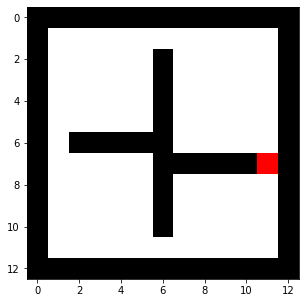

In [10]:
startState = 57
# Simulation
observation = env.reset(startState)
viz.resetMap(phi)

option = policy_over_options.sample(phi)
action = options[option].sample(phi)

for step in range(args.nsteps):
    observation, reward, done, _ = env.step(action)
    phi = features(observation)

    #render
    clear_output(wait=True)
    viz.showMap(phi, option)

    if options[option].terminate(phi):
        option = policy_over_options.sample(phi)

    action = options[option].sample(phi)

    if done:
        break

## Display action and option preference in each state

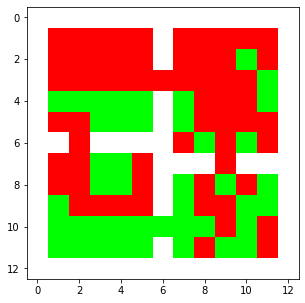

In [8]:
# Display option preference
viz.showPref(policy_over_options.weights)

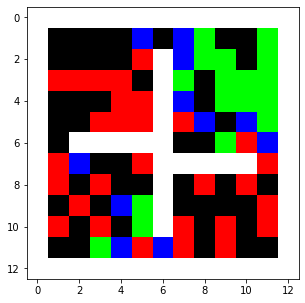

In [17]:
opt = 1
# Display action preference for opt
viz.showPref(options[opt].weights)

## Display Attention

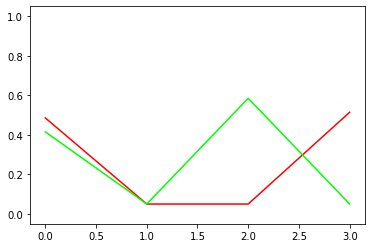

In [166]:
viz.showAttention(options)